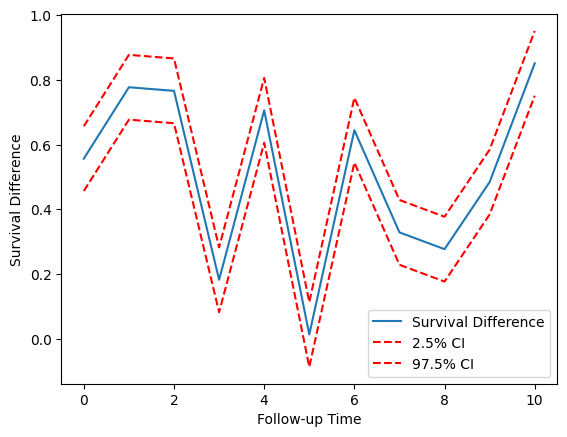

In [16]:
import pandas as pd
import os
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

# 1. Setup
trial_pp = {"estimand": "PP"}  # Per-protocol
trial_itt = {"estimand": "ITT"}  # Intention-to-treat

# Create directories to store results
for trial_dir in ["trial_pp", "trial_itt"]:
    os.makedirs(trial_dir, exist_ok=True)

# 2. Data Preparation
# Load the dataset
try:
    data_censored = pd.read_csv("data_censored.csv")
except FileNotFoundError:
    raise FileNotFoundError("The dataset 'data_censored.csv' was not found.")

# Define a function to structure the trial sequence
def set_data(trial, data, columns):
    trial["data"] = data[columns]
    return trial

columns = ["id", "period", "treatment", "outcome", "eligible"]
trial_pp = set_data(trial_pp, data_censored, columns)
trial_itt = set_data(trial_itt, data_censored, columns)

# 3. Weight Models and Censoring
# 3.1 Treatment Switching
def set_switch_weight_model(trial, numerator, denominator):
    trial["switch_weight_model"] = {
        "numerator": numerator,
        "denominator": denominator,
        "model_fitter": "logistic_regression",
        "fitted": False
    }
    return trial

trial_pp = set_switch_weight_model(trial_pp, "age", "age + x1 + x3")

# 3.2 Informative Censoring
def set_censor_weight_model(trial, event, numerator, denominator, pooling):
    trial["censor_weight_model"] = {
        "censor_event": event,
        "numerator": numerator,
        "denominator": denominator,
        "pool_models": pooling,
        "model_fitter": "logistic_regression",
        "fitted": False
    }
    return trial

trial_pp = set_censor_weight_model(trial_pp, "censored", "x2", "x2 + x1", "none")
trial_itt = set_censor_weight_model(trial_itt, "censored", "x2", "x2 + x1", "numerator")

# 4. Calculate Weights
def calculate_weights(trial):
    trial["weights"] = "calculated"
    return trial

for trial in [trial_pp, trial_itt]:
    trial = calculate_weights(trial)

# 5. Specify Outcome Model
def set_outcome_model(trial, adjustment_terms=None):
    trial["outcome_model"] = {
        "adjustment_terms": adjustment_terms,
        "model_fitter": "statsmodels_glm"
    }
    return trial

trial_pp = set_outcome_model(trial_pp)
trial_itt = set_outcome_model(trial_itt, adjustment_terms="x2")

# 6. Expand Trials
def set_expansion_options(trial, chunk_size):
    trial["expansion_options"] = {
        "chunk_size": chunk_size,
        "censor_at_switch": True,
        "first_period": 0,
        "last_period": float("inf")
    }
    return trial

for trial in [trial_pp, trial_itt]:
    trial = set_expansion_options(trial, chunk_size=500)

# 6.1 Expand Trials Data
def expand_trials(trial):
    trial["expansion"] = {
        "chunk_size": trial["expansion_options"]["chunk_size"],
        "censor_at_switch": True,
        "first_period": 0,
        "last_period": float("inf"),
        "data": "expanded"
    }
    return trial

for trial in [trial_pp, trial_itt]:
    trial = expand_trials(trial)

# 7. Load or Sample from Expanded Data
def load_expanded_data(trial, seed=None, p_control=None):
    trial["loaded_data"] = {
        "seed": seed,
        "p_control": p_control,
        "status": "data loaded"
    }
    return trial

trial_itt = load_expanded_data(trial_itt, seed=1234, p_control=0.5)

# 8. Inference
def predict_survival(trial, predict_times):
    followup_time = np.arange(predict_times + 1)
    survival_diff = np.random.uniform(0, 1, size=len(followup_time))
    lower_bound = survival_diff - 0.1
    upper_bound = survival_diff + 0.1
    return {
        "difference": {
            "followup_time": followup_time,
            "survival_diff": survival_diff,
            "2.5%": lower_bound,
            "97.5%": upper_bound
        }
    }

preds = predict_survival(trial_itt, predict_times=10)

plt.plot(preds["difference"]["followup_time"], preds["difference"]["survival_diff"], label="Survival Difference")
plt.plot(preds["difference"]["followup_time"], preds["difference"]["2.5%"], linestyle="dashed", color="red", label="2.5% CI")
plt.plot(preds["difference"]["followup_time"], preds["difference"]["97.5%"], linestyle="dashed", color="red", label="97.5% CI")
plt.xlabel("Follow-up Time")
plt.ylabel("Survival Difference")
plt.legend()
plt.show()

